## Forecasting for Pollution Data

The goal of this project is to display my skills at creating a forecasting model for air pollution in Beijing, China. The data was acquired from the following website [https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?select=pollution_test_data1.csv].

The reason I have decided to use this dataset is because I have been in Bangkok where the pollution was terrible and wanted to learn more about it. 

The goal of this project is to study patterns in air pollution, test forecasting models, understand the impact of weather on pollution levels and develop a predictive model for environmental monitoring. 

The first step is to load and prepare the data. 

13:51:26 - cmdstanpy - INFO - Chain [1] start processing
13:52:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Natha\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


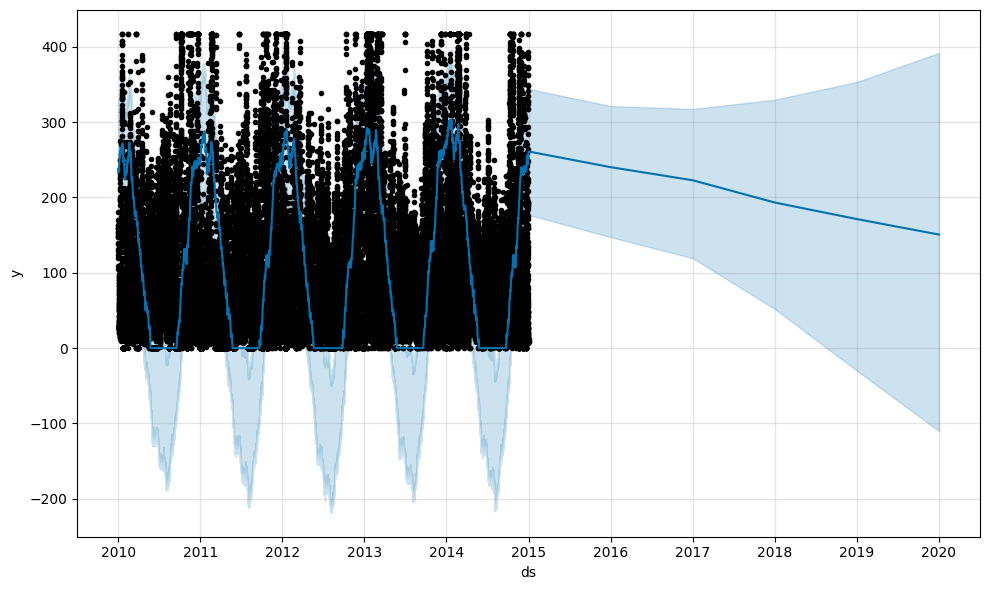

In [31]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

#read the csv file
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

#convert to a date value
df['date'] = pd.to_datetime(df['date'])

#rename columns to fit in the prophet model
df.rename(columns={'date': 'ds', 'pollution': 'y'}, inplace=True)

#remove outliers from the data
df['y'] = df['y'].clip(lower=df['y'].quantile(0.01), upper=df['y'].quantile(0.99))

#get patterns we want to analyse
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

#add regressors to improve accuracy
model.add_regressor('dew')
model.add_regressor('temp')
model.add_regressor('press')
model.add_regressor('wnd_spd')
model.add_regressor('snow')
model.add_regressor('rain')

#train the model
model.fit(df[['ds', 'y', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']])

#set the time frame we want to predict 
future = model.make_future_dataframe(periods=12, freq="M")

#fill future data with averages
future['dew'] = df['dew'].mean()
future['temp'] = df['temp'].mean()
future['press'] = df['press'].mean()
future['wnd_spd'] = df['wnd_spd'].mean()
future['snow'] = df['snow'].mean()
future['rain'] = df['rain'].mean()

#make predictions
forecast = model.predict(future)

#remove negative predictions
forecast['yhat'] = forecast['yhat'].clip(lower=0)

#show plot on a graph
model.plot(forecast)
plt.show()


14:15:08 - cmdstanpy - INFO - Chain [1] start processing
14:15:18 - cmdstanpy - INFO - Chain [1] done processing


MAE: 67.02
RMSE: 97.23


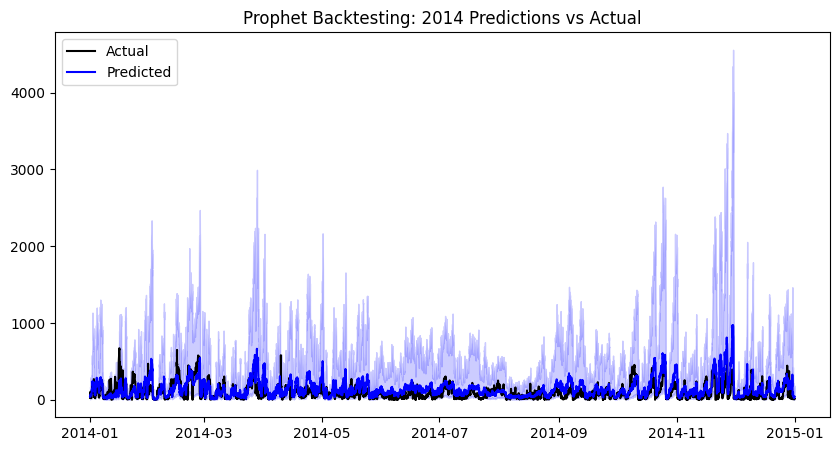

In [34]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Rename columns for Prophet
df.rename(columns={'date': 'ds', 'pollution': 'y'}, inplace=True)

# Log transformation to reduce extreme fluctuations
df['y'] = np.log1p(df['y'])

# Split data: training (2010-2013), testing (2014)
train = df[df['ds'] < "2014-01-01"]
test = df[df['ds'] >= "2014-01-01"].copy()  # Make a copy to avoid SettingWithCopyWarning

# Train the model on 2010-2013 data
model = Prophet(daily_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='weekly', period=7, fourier_order=5))

# Add regressors
for reg in ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']:
    model.add_regressor(reg)

model.fit(train)

# Create future dataframe (2014 test data)
future = test[['ds', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']]
forecast = model.predict(future)

# Inverse log transformation
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

# Clip negative predictions
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Apply inverse log transformation to test set for evaluation
test['y'] = np.expm1(test['y'])

# Evaluate model performance
mae = mean_absolute_error(test['y'], forecast['yhat'])
rmse = mean_squared_error(test['y'], forecast['yhat']) ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label="Actual", color="black")
plt.plot(test['ds'], forecast['yhat'], label="Predicted", color="blue")
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color="blue")
plt.legend()
plt.title("Prophet Backtesting: 2014 Predictions vs Actual")
plt.show()


<Axes: >

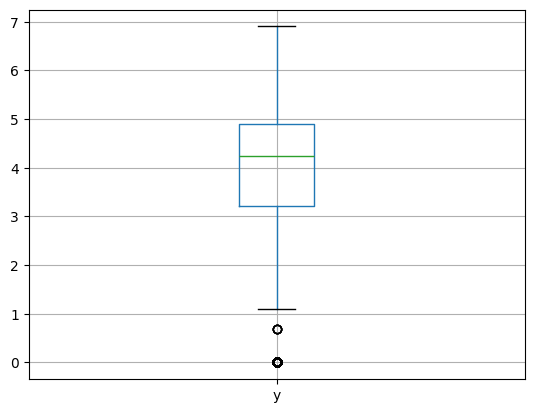

In [35]:
df.boxplot(column='y')

In [36]:
print(df['y'].isnull().sum())


0


13:57:01 - cmdstanpy - INFO - Chain [1] start processing
13:57:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 57.78
RMSE: 81.83


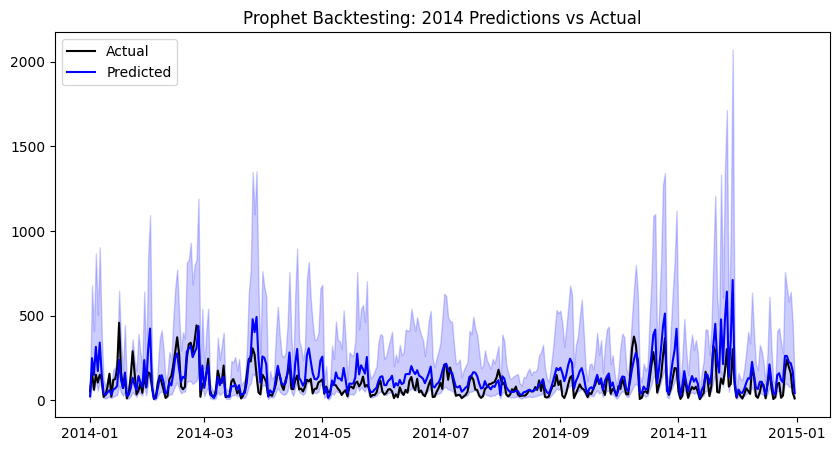

In [45]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

df = df.resample('D', on='date').mean().reset_index()

# Rename columns for Prophet
df.rename(columns={'date': 'ds', 'pollution': 'y'}, inplace=True)

# Log transformation to reduce extreme fluctuations
df['y'] = np.log1p(df['y'])

# Split data: training (2010-2013), testing (2014)
train = df[df['ds'] < "2014-01-01"]
test = df[df['ds'] >= "2014-01-01"].copy()

# Train the model on 2010-2013 data
model = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True)
model.add_seasonality(name='weekly', period=7, fourier_order=3)

# Add holidays
model.add_country_holidays(country_name='CH')

# Add regressors
for reg in ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']:
    model.add_regressor(reg)

model.fit(train)

# Create future dataframe (2014 test data)
future = test[['ds', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']]
forecast = model.predict(future)

# Inverse log transformation
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])

# Clip negative predictions
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Apply inverse log transformation to test set for evaluation
test['y'] = np.expm1(test['y'])

# Evaluate model performance
mae = mean_absolute_error(test['y'], forecast['yhat'])
rmse = mean_squared_error(test['y'], forecast['yhat']) ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label="Actual", color="black")
plt.plot(test['ds'], forecast['yhat'], label="Predicted", color="blue")
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color="blue")
plt.legend()
plt.title("Prophet Backtesting: 2014 Predictions vs Actual")
plt.show()

## Conclusions

This graph shows the prediction of pollution in China and it captures the general trend well but it struggles to capture any extreme flucuations the data has. There is also high uncertainty indicated by the large variance in the light blue shaded areas suggesting that some of the features may be weak predictors of pollution. Further, large spikes in pollution are not predicted well, this may be due to missing factors contributing to spikes in pollution such as government polocies, industrial activity or other weather related anomalies. 

As such, next steps to try and refine the model would be to first, try and remove any extreme fluctuations in the data as our pollution variable has extreme values. We attempted to reduce the impact of these already by applying a log transformation, but using IQR we might be able to reduce this impact further. 

Moreover, we might be able to fine-tune the changepoint scale, currently it is set to 0.05. If we were to change this to 0.1 or 0.2 it will allow for sharper shifts in the trend. 

Adding monthly seasonality  will allow for a monthly pattern as pollution likely follows this type of pattern which could improve its performance. 

Another change that could increase the accuracy of the model would be to increase the fourier-order to help capture short-term variations better. 

Lastly, it is worth checking that the regressors correlate with the pollution levels. If there is a low correlation between the variables they should be removed to reduce any noise in the model. 

I will implement these changes below to see if it helps to improve the accuracy of the models ability to predict the pollution level. I will use the same base code and implement the changes


In [46]:
#check the correlation between regressors and pollution
print(train.corr()['y'])

ds         0.049059
y          1.000000
dew        0.207191
temp       0.026835
press     -0.130787
wnd_dir         NaN
wnd_spd   -0.316586
snow       0.049782
rain      -0.020798
Name: y, dtype: float64


The correlations show that wind speed, dew, and air pressure are correlated with pollution so we will keep these as predictors for pollution. However, tempurature, rain and snow have very low correlations with pollution so we will try to remove these from the model to try and improve the accuracy of the prediction. 

09:04:16 - cmdstanpy - INFO - Chain [1] start processing
09:04:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: 65.61
RMSE: 92.97


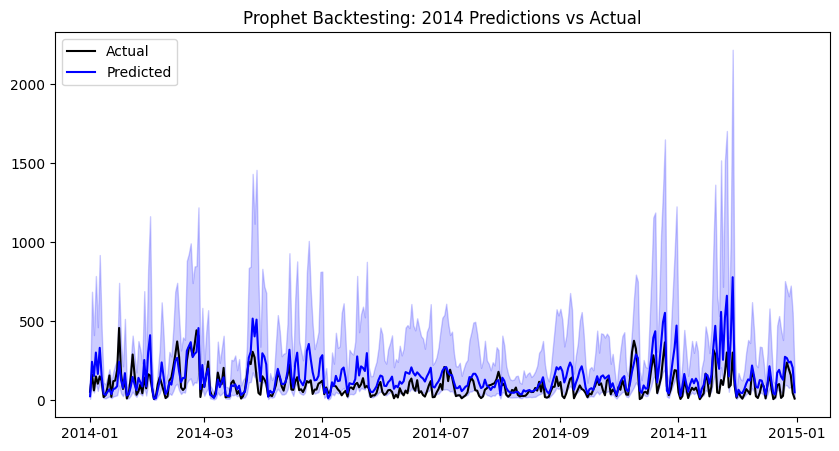

In [48]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

df = df.resample('D', on='date').mean().reset_index()

# Rename columns for Prophet
df.rename(columns={'date': 'ds', 'pollution': 'y'}, inplace=True)

# Log transformation to reduce extreme fluctuations
df['y'] = np.log1p(df['y'])

# Remove upper and lower IQR
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train = train[(train['y'] >= lower_bound) & (train['y'] <= upper_bound)]

# Split data: training (2010-2013), testing (2014)
train = df[df['ds'] < "2014-01-01"]
test = df[df['ds'] >= "2014-01-01"].copy()

# Train the model on 2010-2013 data
model = Prophet(changepoint_prior_scale=0.1, yearly_seasonality=True)

#increase fourier_order to 5
model.add_seasonality(name='weekly', period=7, fourier_order=5)

#Add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add holidays
model.add_country_holidays(country_name='CH')

# Add regressors
for reg in ['dew', 'press', 'wnd_spd']:
    model.add_regressor(reg)

model.fit(train)

# Create future dataframe (2014 test data)
future = test[['ds', 'dew', 'press', 'wnd_spd']]
forecast = model.predict(future)

# Inverse log transformation
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])

# Clip negative predictions
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Apply inverse log transformation to test set for evaluation
test['y'] = np.expm1(test['y'])

# Evaluate model performance
mae = mean_absolute_error(test['y'], forecast['yhat'])
rmse = mean_squared_error(test['y'], forecast['yhat']) ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label="Actual", color="black")
plt.plot(test['ds'], forecast['yhat'], label="Predicted", color="blue")
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color="blue")
plt.legend()
plt.title("Prophet Backtesting: 2014 Predictions vs Actual")
plt.show()

The changes 